In [1]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import itertools
import numpy as np
import pandas as pd
from scipy import stats
import io

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_style('whitegrid')
sns.set_palette('colorblind')
 
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

In [2]:
#OUTDIR = '/mnt/dv/wid/projects5/Roy-singlecell/scRNAseq_NetInference/Final_figures/'
OUTDIR = '/mnt/dv/wid/projects5/Roy-singlecell/scRNAseq_NetInference/Final_figures/figure_panels_Jan26'
if not os.path.exists(OUTDIR):
    os.mkdir(OUTDIR)
    
WORKDIR = '/mnt/dv/wid/projects5/Roy-singlecell/scRNAseq_NetInference/'
os.chdir(WORKDIR)

In [3]:
import yaml
config = yaml.load(open('/mnt/dv/wid/projects5/Roy-singlecell/scRNAseq_NetInference/snakefiles/04_evaluation/fscore.yaml'),
                   Loader=yaml.FullLoader)

ALGORITHMS = sorted(config['algorithms'], key=lambda s: s.lower())
ALGORITHMS = [a for a in ALGORITHMS if a not in ['pearson', 'random', 'ensemble']] + ['pearson']

In [4]:
ALGORITHMS = 'pearson inferelator kNN-DREMI LEAP PIDC Scribe SILGGM MERLIN SCENIC SCODE random'.split()
ALGORITHMS = sorted(ALGORITHMS, key=lambda s: s.lower())

In [5]:
ALG_FIX = {
    'inferelator': 'Inferelator',
    'knnDREMI': 'kNN-DREMI',
    'pearson': 'Pearson',
    'random': 'Random'
}

ALGORITHMS = [ALG_FIX.get(a, a) for a in ALGORITHMS]

In [6]:
alg_fix = {
    'inferelator': 'Inferelator',
    'knnDREMI': 'kNN-DREMI',
    'pearson': 'Pearson',
    'random': 'Random'
}

ALGORITHMS = [alg_fix.get(a, a) for a in ALGORITHMS]

Set order, grouped by species

In [7]:
DATASETS = [
    'gasch_GSE102475',
    'jackson_GSE125162',
    'sridharan_A2S',
    'sridharan_FBS',
    'zhao_GSE114952',
    'shalek_GSE48968',
    'han_GSE107552'
]

## Load data

In [8]:
def filter_GS(df):
    # Restrict to gold standards of interest
    # KD, chip, and intersect
    cell_types = 'yeast mESC mDC hESC'.split()
    GS_types ='KDUnion chipunion chipunion_KDUnion_intersect'.split()
    GS_srcs = ['_'.join(x) for x in itertools.product(cell_types, GS_types)]
    df = df.loc[df.GS_src.isin(GS_srcs)].copy()

    # Rename gold standards for plotting
    df.GS_src = df.GS_src.str.split('_').str[1:].str.join('_')
    df.GS_src = df.GS_src.replace({'KDUnion': 'Perturb', 
                                   'chipunion': 'ChIP',
                                   'chipunion_KDUnion_intersect': 'Perturb+ChIP'})
    
    return df

## Edited by Jiaxin: edited file path to load from /mnt/dv/wid/projects5/Roy-singlecell/netinf_algo_comparison

In [9]:
def load_scores(metric):    
    normalized = pd.read_table('/mnt/dv/wid/projects5/Roy-singlecell/scRNAseq_NetInference/results/{0}/agg_{0}.normalized.txt'.format(metric))
    imputed = pd.read_table('/mnt/dv/wid/projects5/Roy-singlecell/scRNAseq_NetInference/results/{0}/agg_{0}.imputed.txt'.format(metric))

    scores = pd.concat([normalized, imputed])
    
    scores.algorithm = scores.algorithm.replace(alg_fix)
    scores = scores.loc[scores.algorithm.isin(ALGORITHMS)]
    
    return filter_GS(scores)

In [10]:
N_EDGES = 5000
idx_cols = ['dataset', 'algorithm', 'proc', 'GS_src']

In [11]:
fscores = load_scores("fscores")
fscores = fscores.loc[fscores.n_edges == N_EDGES]\
                 .drop('n_edges', axis=1)\
                 .set_index(idx_cols)

In [12]:
predTFs = load_scores("predictable_TFs")
predTFs = predTFs.loc[predTFs.n_edges == N_EDGES]\
                 .drop('n_edges', axis=1)\
                 .set_index(idx_cols)

In [13]:
aupr = load_scores('AUPR')
aupr = aupr.drop('n_edges', axis=1).set_index(idx_cols)

In [14]:
scores = pd.concat([fscores, aupr, predTFs], axis=1).reset_index()

In [25]:
scores.loc[scores['dataset'] == 'shalek_GSE48968',]

,dataset,algorithm,proc,GS_src,precision,recall,fscore,AUPR,n_TFs,pred_TFs
12,shalek_GSE48968,Inferelator,normalized,ChIP,0.5502,0.0285,0.0543,0.478328,11,"Atf3,Atf4,Egr1,Egr2,Irf2,Nfkb1,Rel,Relb,Stat1,..."
13,shalek_GSE48968,Inferelator,normalized,Perturb,0.4452,0.0150,0.0291,0.210957,6,"Atf3,Cebpb,Hsp90b1,Jak2,Nfkb1,Stat1"
14,shalek_GSE48968,Inferelator,normalized,Perturb+ChIP,0.4794,0.0354,0.0659,0.392222,10,"Atf3,Cebpb,Egr2,Irf2,Nfkb1,Rel,Relb,Stat1,Stat..."
33,shalek_GSE48968,kNN-DREMI,normalized,ChIP,0.2728,0.0142,0.0269,0.453317,0,NaN
34,shalek_GSE48968,kNN-DREMI,normalized,Perturb,0.1934,0.0068,0.0131,0.365356,0,NaN
...,...,...,...,...,...,...,...,...,...,...
415,shalek_GSE48968,SILGGM,imputed,Perturb,0.1142,0.0040,0.0078,0.275792,0,NaN
416,shalek_GSE48968,SILGGM,imputed,Perturb+ChIP,0.1926,0.0142,0.0265,0.308631,0,NaN
435,shalek_GSE48968,Random,imputed,ChIP,0.4512,0.0234,0.0445,0.465217,0,NaN
436,shalek_GSE48968,Random,imputed,Perturb,0.3500,0.0123,0.0238,0.353577,0,NaN


## Per-alg

In [15]:
def format_did(dataset):
    """Convert dataset ID to axis title"""
    
    dname, geo = dataset.split('_')
    
    if dname == 'sridharan':
        return 'Tran ({0})'.format(geo)
    else:
        return dname.capitalize()

In [16]:
METRICS = ['fscore', 'precision', 'n_TFs', 'AUPR']
METRICS = ['fscore', 'AUPR','n_TFs']
METRIC_TITLES = {'fscore': 'F-score', 'precision': 'Precision', 'AUPR': 'AUPR', 'n_TFs': 'Predictable TFs'}

In [17]:
MARKERS = 'o v ^ < > s p P * x X D d'.split()

In [18]:
ALGORITHMS = ['Pearson', 'SCENIC', 'MERLIN','PIDC', 'LEAP', 'SCODE','Scribe', 'SILGGM', 'Inferelator', 'kNN-DREMI']


In [19]:
METRICS

['fscore', 'AUPR', 'n_TFs']

This is the dataset name: gasch_GSE102475 And the axmax is 0.0824
This is the dataset name: jackson_GSE125162 And the axmax is 0.0551
This is the dataset name: sridharan_A2S And the axmax is 0.13
This is the dataset name: sridharan_FBS And the axmax is 0.137
This is the dataset name: zhao_GSE114952 And the axmax is 0.1581
This is the dataset name: shalek_GSE48968 And the axmax is 0.1577
This is the dataset name: han_GSE107552 And the axmax is 0.1364
This is the dataset name: gasch_GSE102475 And the axmax is 0.0756
This is the dataset name: jackson_GSE125162 And the axmax is 0.0517
This is the dataset name: sridharan_A2S And the axmax is 0.2526
This is the dataset name: sridharan_FBS And the axmax is 0.2621
This is the dataset name: zhao_GSE114952 And the axmax is 0.2331
This is the dataset name: shalek_GSE48968 And the axmax is 0.9346
This is the dataset name: han_GSE107552 And the axmax is 0.4203
This is the dataset name: gasch_GSE102475 And the axmax is 26.4
This is the dataset name:

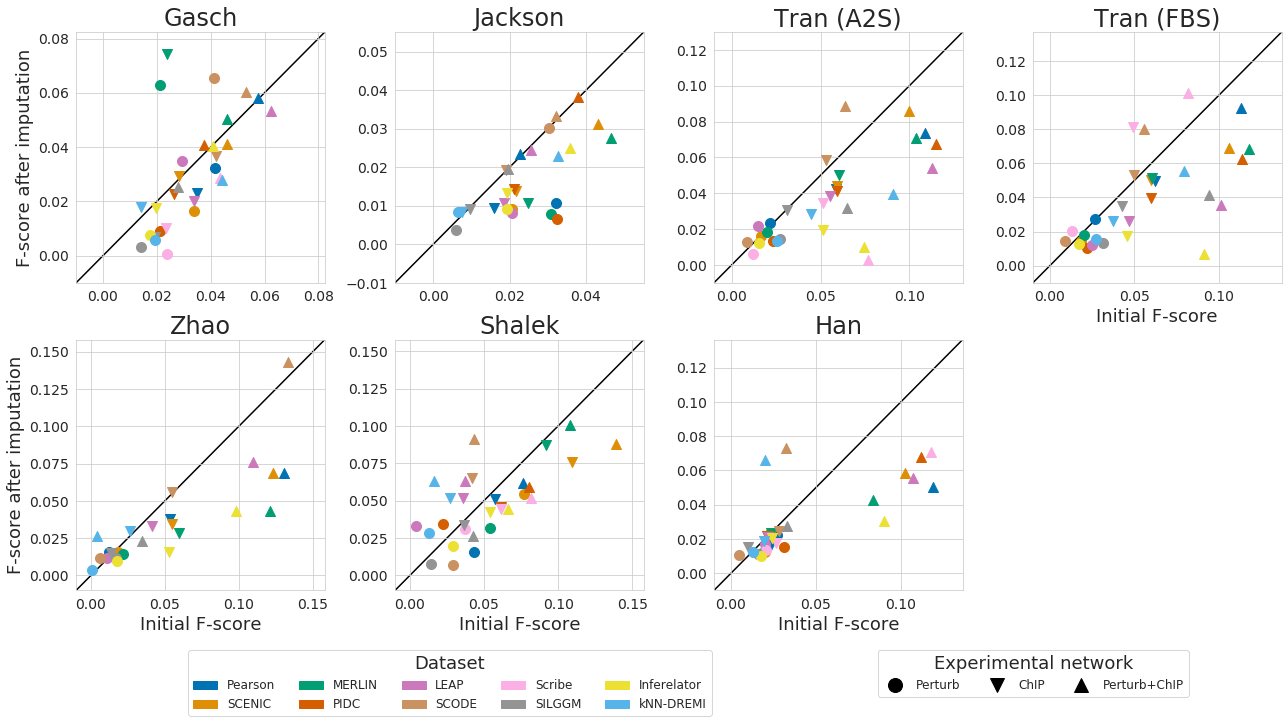

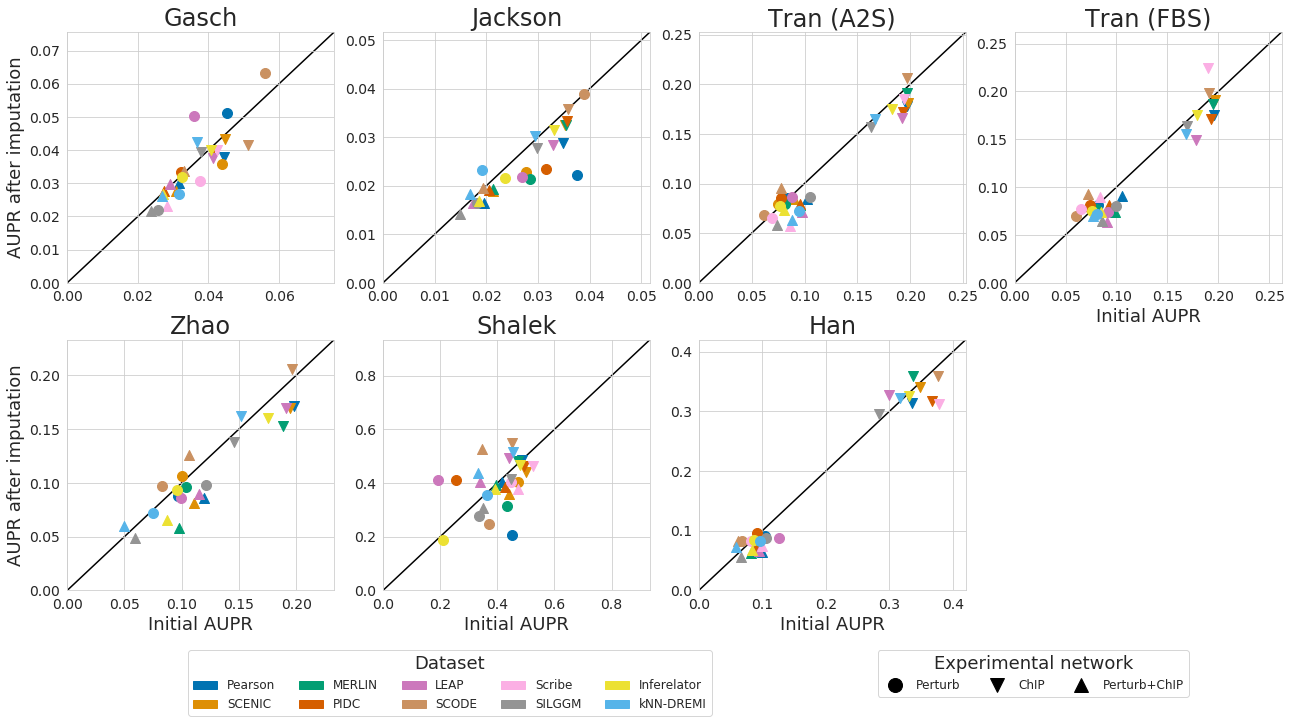

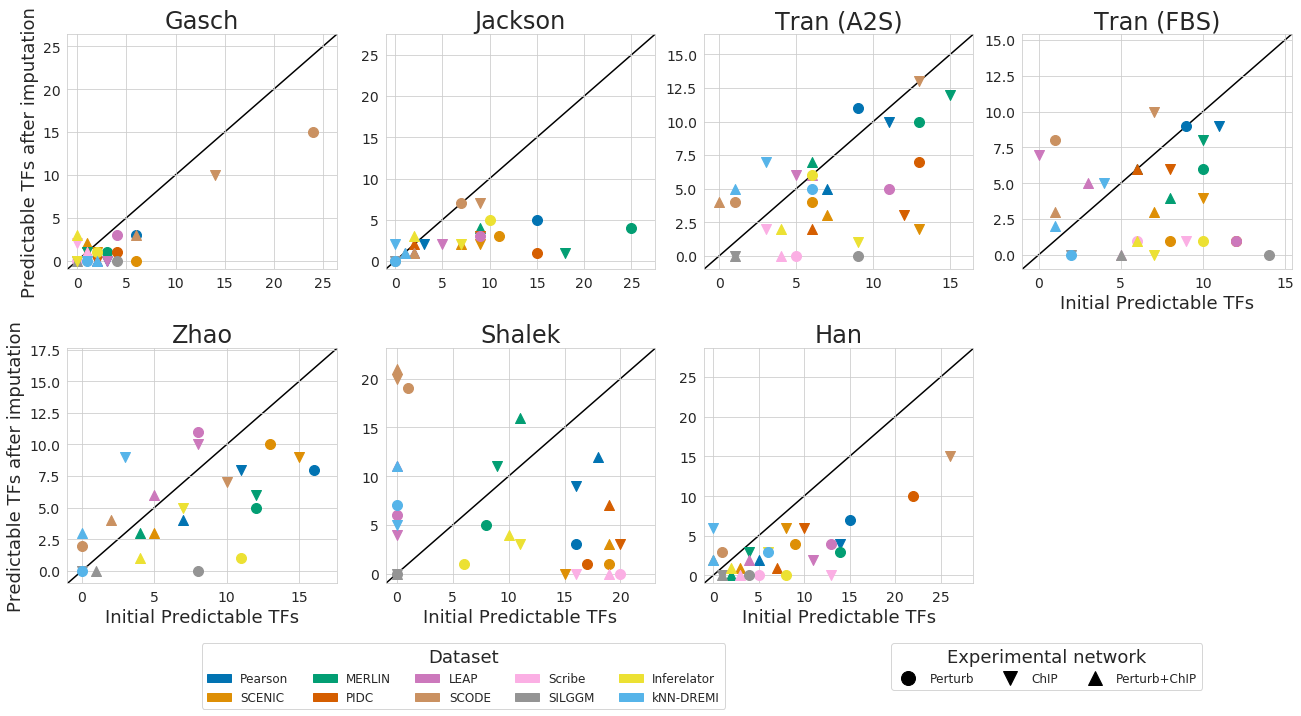

In [22]:
for metric in METRICS:
    paired = scores.pivot_table(index=['dataset', 'algorithm', 'GS_src'],
                                columns='proc',
                                values=metric)\
                   .reset_index()
    
    fig, axes = plt.subplots(2, 4, figsize=(18, 9))#, sharey=True, sharex=True)

    for k, (dataset, ax) in enumerate(zip(DATASETS, axes.flat)):
        data = paired.loc[paired.dataset == dataset]

        for i, algorithm in enumerate(ALGORITHMS):
            df = data.loc[data.algorithm == algorithm]

            for j, GS in enumerate(['Perturb', 'ChIP', 'Perturb+ChIP']):
                d2 = df.loc[df.GS_src == GS]

                ax.scatter(d2.normalized, d2.imputed, 
                           color=sns.color_palette('colorblind')[i], 
                           marker=MARKERS[j], s=100)

        ax.plot((-50, 50), (-50, 50), color='black', zorder=0)

        # Scale axes
        if metric == "AUPR":
            max_score = max(df['normalized'].values.max(), df['imputed'].values.max())
            min_score = min(df['normalized'].values.min(), df['imputed'].values.min())
#             max_score = max(data['normalized'].values.max(), data['imputed'].values.max())
#             min_score = min(data['normalized'].values.min(), data['imputed'].values.min())
        else:
            max_score = max(data['normalized'].values.max(), data['imputed'].values.max())
            min_score = min(data['normalized'].values.min(), data['imputed'].values.min())
        
        axmax = np.round((max_score + min_score) * 1.1, 4)
        print(f"This is the dataset name: {dataset} And the axmax is {axmax}")
        if metric == "n_TFs":
            ax.set_xlim(-1, axmax)
            ax.set_ylim(-1, axmax)
        elif metric == "AUPR":
            ax.set_xlim(0, axmax)
            ax.set_ylim(0, axmax)
        else:
            ax.set_xlim(-0.01, axmax)
            ax.set_ylim(-0.01, axmax)

        # Labels
        if k >= 3:
            ax.set_xlabel('Initial {0}'.format(METRIC_TITLES[metric]), fontsize=18)
        if k % 4 == 0:
            ax.set_ylabel('{0} after imputation'.format(METRIC_TITLES[metric]), fontsize=18)
        ax.set_title(format_did(dataset), fontsize=24)#, fontweight='bold')

    # Hide unused axis
    axes.flat[-1].axis('off')

    # plt.subplots_adjust(top=0.93)
    # fig.suptitle('F-score - normalized vs imputed')
    # plt.subplots_adjust(hspace=-0.2)
    plt.tight_layout()

    # plt.savefig(os.path.join(OUTDIR, '20190719_normalized_vs_imputed_aupr.per_alg.pdf'), bbox_inches='tight')

    palette = sns.color_palette('colorblind')
    alg_patches = [mpatches.Patch(color=c, label=alg) for c, alg in zip(palette, ALGORITHMS)]
    # dataset_patches = [mpatches.Patch(facecolor='k', marker=m, label=dataset) for m, dataset in zip(MARKERS, DATASETS)]
    GS_patches = [ plt.plot([],[], marker=m, ms=14, ls="", mec=None, color='k', 
                                 label=GS_src)[0]  for m, GS_src in zip(MARKERS, ['Perturb', 'ChIP', 'Perturb+ChIP'])]

    l = fig.legend(handles=alg_patches, prop=dict(size=12), ncol=5,
                   loc='upper center', title='Dataset', 
                   bbox_to_anchor=(0.35, 0), bbox_transform=fig.transFigure)
    l.get_title().set_fontsize(18)

    l = fig.legend(handles=GS_patches, prop=dict(size=12), ncol=3,
                   loc='upper center', title='Experimental network', 
                   bbox_to_anchor=(0.8, 0), bbox_transform=fig.transFigure)
    l.get_title().set_fontsize(18)
    fname = format(metric)+".pdf"
    
    #png1 = io.BytesIO()
    plt.savefig(os.path.join(OUTDIR,fname), bbox_inches='tight')

## performance relative to normalized

todo: move this to above

In [23]:
melted = pd.melt(scores, id_vars=['dataset', 'algorithm', 'proc', 'GS_src'],
                value_vars=['fscore', 'precision', 'AUPR', 'n_TFs'], 
                var_name='metric', value_name='score')

In [24]:
paired = melted.pivot_table(index=['dataset', 'algorithm', 'GS_src', 'metric'],
                            columns='proc', values='score').reset_index()

In [25]:
paired['diff'] = paired.imputed - paired.normalized
paired['log2_ratio'] = np.log2(paired.imputed / paired.normalized)

/mnt/ws/home/jli/.local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
dataset_titles = ['Gasch', 'Jackson', 'Tran (A2S)', 'Tran (FBS)', 'Zhao', 'Shalek', 'Han']

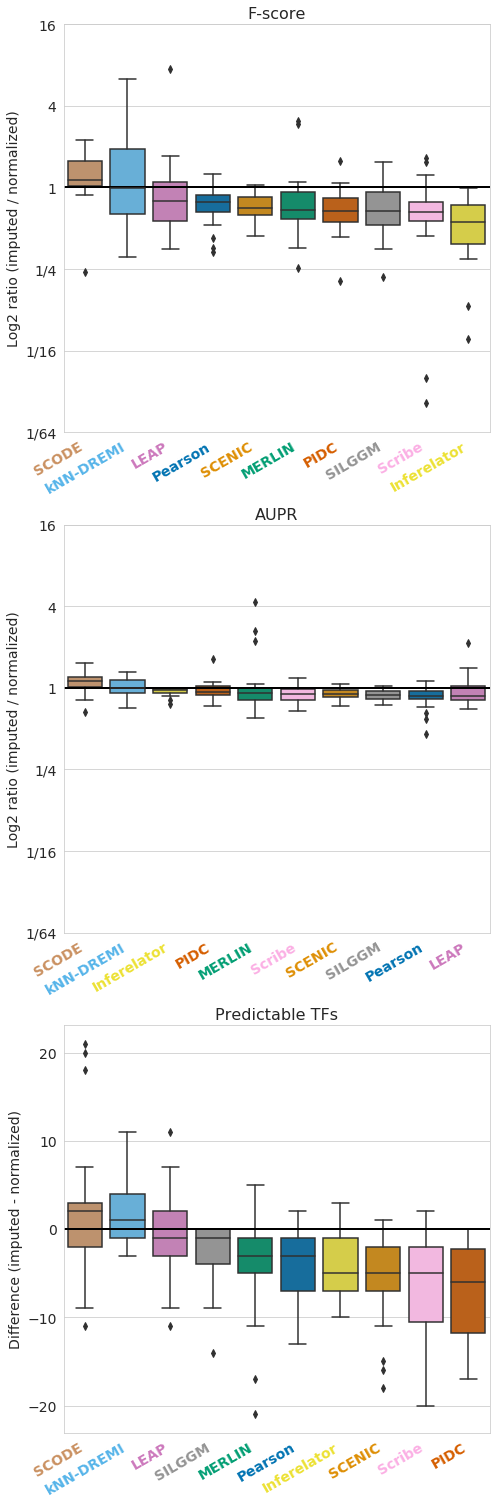

In [28]:
fig, axes = plt.subplots(3, 1, figsize=(7, 21))

for metric, ax in zip(['fscore', 'AUPR', 'n_TFs'], axes.flat):
    dat = paired.loc[(paired.metric == metric) &
                     (paired.algorithm != 'Random')]
    
    if metric == 'n_TFs':
        comparison = 'diff'
    else:
        comparison = 'log2_ratio'

    order = dat.groupby('algorithm')[comparison].median().sort_values(ascending=False).index
    order = [a for a in order if a != 'Random']
    idx_order = [ALGORITHMS.index(a) for a in order]
    palette = [sns.color_palette('colorblind')[i] for i in idx_order]

    ax = sns.boxplot(data=dat, y=comparison, ax=ax,
                      x='algorithm', order=order, palette=palette)

    ax.axhline(0, c='k', linewidth=2)

    ax.set_xticklabels([ALGORITHMS[i] for i in idx_order], rotation=30, ha='right')
    [t.set_color(i) for i, t in zip(palette, ax.xaxis.get_ticklabels())]
    [t.set_fontweight('bold') for t in ax.xaxis.get_ticklabels()]

    ax.set_xlabel('')
    if comparison == 'log2_ratio':
        ax.set_ylabel("Log2 ratio (imputed / normalized)")
        ax.set_ylim(-6, 4)
        ax.set_yticks(np.arange(-6, 6, 2))
        ax.set_yticklabels(['1/64', '1/16', '1/4', '1', '4', '16'])
    else:
        ax.set_ylabel("Difference (imputed - normalized)")    
    ax.set_title(METRIC_TITLES[metric])

    plt.tight_layout()

plt.savefig(os.path.join(OUTDIR, 'fig.7b&7d&7f.pdf'), bbox_inches='tight')

NameError: name 'ALG_TITLES' is not defined

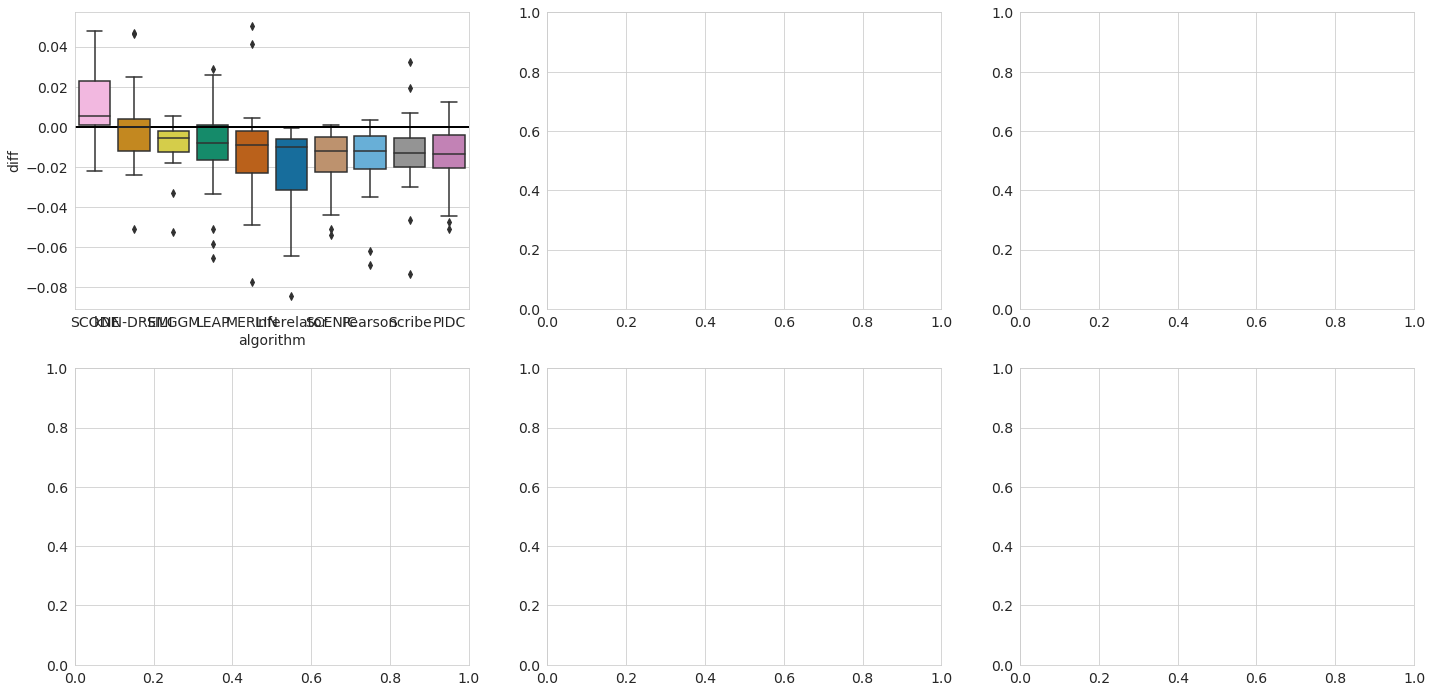

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(24, 12))
for axrow, comparison in zip(axes, ['diff', 'log2_ratio']):
    for metric, ax in zip(METRICS, axrow):
        dat = paired.loc[paired.metric == metric]

        order = dat.groupby('algorithm')[comparison].median().sort_values(ascending=False).index
        order = [a for a in order if a != 'random']
        idx_order = [ALGORITHMS.index(a) for a in order]
        palette = [sns.color_palette('colorblind')[i] for i in idx_order]
        
        ax = sns.boxplot(data=dat, y=comparison, ax=ax,
                          x='algorithm', order=order, palette=palette)
        
        ax.axhline(0, c='k', linewidth=2)

        ax.set_xticklabels([ALG_TITLES[i] for i in idx_order], rotation=30, ha='right')
        [t.set_color(i) for i, t in zip(palette, ax.xaxis.get_ticklabels())]
        [t.set_fontweight('bold') for t in ax.xaxis.get_ticklabels()]


        ax.set_xlabel('')
        if comparison == 'log2_ratio':
            ax.set_ylabel("Log2 ratio (imputed / normalized)")
            ax.set_ylim(-2, 2)
            ax.set_yticks(np.arange(-2, 3))
            ax.set_yticklabels(['1/4', '1/2', '1', '2', '4'])
        else:
            ax.set_ylabel("Difference (imputed - normalized)")    
        ax.set_title(METRIC_TITLES[metric])
        
        plt.tight_layout()
        
plt.savefig(os.path.join(OUTDIR, 'imputed_vs_normalized_boxplots.pdf'), bbox_inches='tight')